## The Battle of Neighborhoods in Metro Vancouver
 ### - IBM data science capstone project

### Table of Contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

### Introduction - A description of the problem and a discussion of the background.<a name="introduction"></a>

Vancouver is a very multicultural city, with a strong Asian presence that has seen high levels of migration from Mainland China and Hong Kong over the last two decades.
In recent years Metor Vancouver has also evolved into one of the world’s most expensive cities, and was recently rated as having the highest cost of living of any North American city. Even with the much higher cost, Metro Vancouver is still one of the top immigration destination in Canada. The new immigrants coming to the city are mostly not able to make decision to buy one of the properties in the area before settling down and finding a stable job.

In this project we will help one of our clients recently immigrate to Metro Vancouver from China to find the optimal neighborhood to settle in.
They are trying to rent a property first to get to know the city.
* They will not be driving at first so they are looking for a neighborhood with easy access to the public transportation.
* They are not very adapted to the western food culture yet so they are looking for a neighborhood with lots of East Asian cuisine nearby to choose from.
* They are looking for a neighborhood with lots green space nearby, preferably a big park.
They did not emphasize the necessity of being closer to downtown, so we will explore the entire Metro Vancouver area to find the neighborhoods with **easy access to the Sky-train system**, lots of quality **East Asian food restaurants** nearby and at least one **big park** nearby.

We will use data science technique and statistics analysis to generate a few most promising neighborhoods based on these criteria. Neighborhoods will be visualized on a map and we will present the advantage of these locations.

Other interested audiences could be other new comers from various culture and background. With similar analysis method they will be able to find the ideal neighborhood to start their new life in an unfamiliar city.


### Data - A description of the data and how it will be used to solve the problem. <a name='data'></a>

Based on the definition of the problem we are trying to solve, we will use data science answer 4 questions:
1. What is a  characteristics of this neighborhood? 
2. how many asian food restaurants are in the neighborhood, what is the quality of these restaurants?
3. how many parks are in the neighborhood?
4. Is there at least one Sky-train station nearby (within 2km from the center of the neighborhood)?

The data sources we acquired to answer above questions and find the optimal neighborhoods are:
1. a list of neighborhood candidates. (We will scrape **wikipedia page 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V'** to find the first 3 digits of the postal code of each neighborhood, use **geocoder with arcgis** to find the center of the neighborhood on the map.)
2. a list of Sky-train stations in Metro Vancouver. (We will scrape **wikipedia page 'https://en.wikipedia.org/wiki/List_of_Vancouver_SkyTrain_stations'** to find name of each station and use **Nominatim** to locate each stations on the map.)
3. **Foursquare API** to find venues nearby each neighborhood candidate and sky-train station (1km radius). (map top 10 venues of each neighborhood and use k-mean clustering technic to separate the neighborhoods into 4 clusters, observe the cluster and identify the difference of characteristics of each cluster)
4. Use venue category from Foursquare we will be able to generate a list of neighborhoods with the most East Asian restaurants and parks nearby. Foursquare API premium calls will provide the ratings of each restaurant so we can find out the quality of the food.
5. Cross referencing the nearby venues of the neighborhood and the stations we will find the stations with the close distance to the center of the neighborhood (max range about 2km)


In [1]:
# to read html, scraping tables
!pip install lxml    
import pandas as pd
import numpy as np 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Leonardo\anaconda3

  added / updated specs:
    - folium=0.5.0


The following packages will be UPDATED:

  conda                       pkgs/main::conda-4.8.3-py37_0 --> conda-forge::conda-4.8.3-py37hc8dfbb8_1


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Libraries imported.


-To create a dataframe will consist of three columns: PostalCode, Borough, and Neighborhood. We will focus on the neighborhoods in Great Vancouver which more likely to have skytrain stations nearby and we will limit our neighborhood exploration to four Borough including Vancouver, Richmond, Burnaby, Surrey and New Westminster. (This will not cover North Vancouver and West Vancouver as they are on the other side of bridge and have no skytrain available.)

In [ ]:
# scrape postcode starting of 'V'from the wikipedia page
raw=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V')
raw_list=(raw[0]).values.flatten() # flatten the list
df = pd.DataFrame(raw_list) 
df['postalcode']=df[0].str[:3]
df['address']=df[0].str[3:]

# address contains vancouver
df1=df[df.address.str.contains('Vancouver|Burnaby')]
df1=df1[~df1.address.str.contains('North Vancouver|West Vancouver')] # take out North Vancouver and West Vancouver
df1['borough']=df1.address.str.replace(r"\(.*\)","")
df1['borough']=df1.borough.apply(lambda x: x.strip())
df1['Neighborhood'] = df1.address.str.extract(('.*\((.*)\).*'),expand=False)
df1['Neighborhood'] = df1['Neighborhood'].str.replace(" / ",",")

# address contains Surrey
df2=df[df.address.str.contains('Surrey')]
df2['borough']=df2.address.str[:6]
df2['Neighborhood']=df2.address.str[6:]

# address contains Richmond
df3=df[df.address.str.contains('Richmond')]
df3['borough']=df3.address.str[:8]
df3['Neighborhood']=df3.address.str[8:]
df3.drop([31],inplace=True)

# address contains New Westminster
df4=df[df.address.str.contains('New Westminster')]
df4['borough']=df4.address.str[:15]
df4['Neighborhood']=df4.address.str[15:]

# adress contains Coquitlam
df5=df[df.address.str.contains('Coquitlam')]
df5=df5[~df5.address.str.contains('Port Coquitlam')]
df5['borough']=df5.address.str[:9]
df5['Neighborhood']=df5.address.str[9:]

great_vancouver=[df1,df2,df3,df4,df5]
df_final=pd.concat(great_vancouver)
df_final=df_final.drop([0,'address'],axis=1)
df_final=df_final.reset_index(drop=True)

In [38]:
df_final.head()

,postalcode,borough,neighborhood,latitude,longitude
0,V5A,Burnaby,"Government Road,Lake City,SFU,Burnaby Mountain",49.266244,-122.931096
1,V6A,Vancouver,"Strathcona,Chinatown,Downtown Eastside",49.278421,-123.092971
2,V5B,Burnaby,"Parkcrest-Aubrey,Ardingley-Sprott",49.266060,-122.959220
3,V6B,Vancouver,"NE Downtown,Gastown,Harbour Centre,Internation...",49.280253,-123.115695
4,V5C,Burnaby,"Burnaby Heights,Willingdon Heights,West Centra...",49.275565,-123.002918


In [41]:
df_final.shape[0]

62

-We will explore 62 neighborhoods in Metro Vancouver area.  Now let's add latitude and longtitude of each neighborhood to the dataframe.

In [6]:
# first let's define a function to find the Latitude Longitude based on the postal code (using geocoder and arcgis)
import geocoder
def get_geocoder(postal_code):
     # initialize your variable to None
     lat_lng_coords = None
     # loop until you get the coordinates
     while(lat_lng_coords is None):
       g = geocoder.arcgis('{}, British Columbia'.format(postal_code))
       lat_lng_coords = g.latlng
     latitude = lat_lng_coords[0]
     longitude = lat_lng_coords[1]
     return latitude,longitude

In [7]:
latlng_list=[]
for i in df['postalcode'].values:
    m=list(get_geocoder(i))
    m.append(i)
    latlng_list.append(m)
df_geo=pd.DataFrame(latlng_list,columns=['latitude','longitude','postalcode'])
df_geo.head()

,latitude,longitude,postalcode
0,49.691079,-115.952463,V1A
1,49.491010,-119.574217,V2A
2,49.088009,-122.641184,V3A
3,49.032073,-122.821241,V4A
4,49.266244,-122.931096,V5A


In [42]:
df_final=pd.merge(df_final,df_geo,on='postalcode')

#### Neighborhoods in Metro Vancouver Area

In [43]:
df_final.head()

,postalcode,borough,Neighborhood,latitude,longitude
0,V5A,Burnaby,"Government Road,Lake City,SFU,Burnaby Mountain",49.266244,-122.931096
1,V6A,Vancouver,"Strathcona,Chinatown,Downtown Eastside",49.278421,-123.092971
2,V5B,Burnaby,"Parkcrest-Aubrey,Ardingley-Sprott",49.266060,-122.959220
3,V6B,Vancouver,"NE Downtown,Gastown,Harbour Centre,Internation...",49.280253,-123.115695
4,V5C,Burnaby,"Burnaby Heights,Willingdon Heights,West Centra...",49.275565,-123.002918


-This process takes so long so we will saved it under a csv file

In [ ]:
df_final.to_csv('Vancouver Neighborhood.csv')
print('csv generated')

-Now let's find out the geo locations of the skytrain stations in Metro Vancouver. We scraped the data from Wikipedia.
the dataframe will list all the names of the stations and what line it belongs to, what 'borough it belongs to and Zone information, we might need the information later.

In [10]:
raw1=pd.read_html('https://en.wikipedia.org/wiki/List_of_Vancouver_SkyTrain_stations')
df_station=raw1[1].iloc[:,0:4]
df_station['Station']=df_station['Station'].str.replace('*','')
df_station['Station']=df_station['Station'].str.replace(r"\[.*\]","")
df_station['Station']=df_station['Station'] +' Station'
df_station.head()

,Station,Line(s),Municipality,Zone[a]
0,22nd Street Station,Expo,New Westminster,Zone 2
1,29th Avenue Station,Expo,Vancouver,Zone 1
2,Aberdeen Station,Canada,Richmond,Zone 2
3,Braid Station,Expo,New Westminster,Zone 2
4,Brentwood Town Centre Station,Millennium,Burnaby,Zone 2


-Now add geo information to the dataframe.

In [11]:
station_geo=[]
import time
for n in range(len(df_station)):
    station_address= df_station['Station'][n]+','+'British Columbia'
    geolocator = Nominatim(user_agent="V_explorer") 
    location = geolocator.geocode(station_address) 
    Latitude = location.latitude 
    Longitude = location.longitude
    station_geo.append([df_station['Station'][n],Latitude,Longitude])
    
print('complete')

complete


In [13]:
station_geo=pd.DataFrame(station_geo,columns=['Station','Lat','Lng'])

In [14]:
df_station=pd.merge(df_station,station_geo,on='Station')

In [15]:
df_station['Station']=df_station['Station'].str.replace('–','-')

#### Skytrain stations in Metro Vancouver Area

In [15]:
df_station.head()

,Station,Line(s),Municipality,Zone[a],Lat,Lng
0,22nd Street Station,Expo,New Westminster,Zone 2,49.200065,-122.949015
1,29th Avenue Station,Expo,Vancouver,Zone 1,49.244208,-123.045922
2,Aberdeen Station,Canada,Richmond,Zone 2,49.183982,-123.136316
3,Braid Station,Expo,New Westminster,Zone 2,49.233109,-122.882776
4,Brentwood Town Centre Station,Millennium,Burnaby,Zone 2,49.266402,-123.001724


In [16]:
print(df_station.shape[0])

53


-There are 53 skytrain stations in Metro Vancouver, again this takes very long and we want to save this dataframe into a csv file.

In [ ]:
df_station.to_csv('Vancouver Skytrain Station.csv')
print('csv created')

#### All the data we need is ready now, now we can visualize it on a map.

In [64]:
#find Geo coordinate of center of great vancouver(I use Burnaby,BC here)
geolocator = Nominatim(user_agent="V_explorer")
location = geolocator.geocode('Burnaby,BC')
latitude = location.latitude
longitude = location.longitude
Metro_Vancouver=[latitude,longitude]

-let's now visualize the neighborhood and Stations.

In [110]:
# create map of Vancouver using latitude and longitude values
map_vancouver= folium.Map(location=Metro_Vancouver, zoom_start=11.2)

# Add the skytrain stations, green train icon with popup.  
for lat, lng, station in zip(df_station['Lat'], df_station['Lng'], df_station['Station']):
    label = station
    label = folium.Popup(label, parse_html=False)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='green',icon="train", prefix='fa')
        ).add_to(map_vancouver)
# Add the neighborhoods, red circle with pop up.
for lat, lng, borough, neighborhood in zip(df_final['latitude'], df_final['longitude'], df_final['borough'], df_final['neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='#f51845',
        fill=True,
        fill_color='#e6aab6',
        fill_opacity=0.5,
        parse_html=False).add_to(map_vancouver)
map_vancouver


-By briefly observe the map there are lots of neighberhoods are closed to the skytrain stations.   

### Methodology <a name="methodology"></a>

In order to find the optimal location, throughout the project we will use Foursquare API to querry the nearby venues of each Neighborhood.
1. To find out what neighborhood have the most east asian cuisines, we will analysis the possilble venues categories foursquare will be using and looking for the data corresponding to the correct categories. (radius of 1km will be used and maximum within the radius is set to 300)
2. To find out the average rating of these resturant, the Foursquare API premium calls will be used. Any resturant missing rating will be replaced with the median rating of the entire list.
A boxplot will be used to looking into the deviation of the data by location.
3. To find out how many big park is in the neighborhood, we will use the venue category 'park' to search for the data.
4. To find out the proximity of the skytrain station (less than 2km), we will use Foursquare API to find out the nearby venues of each stations (1km radius), then we will cross referencing the list with the venues we generated before that are closer to the center of the neighborhood. As long as the proximity between the stations and center of the neighborhood is less than 2 km, there will be overlapping venues on both lists.
5. It will be a good starting point to use k-mean clusting to indentify the bigger zone we will be limiting our candidates within, and the cluster will be analysed to show the common characteristics of these neighborhoods.

All the results from the analysis will be put together to form the final recommendation.


### Analysis <a name='analysis'></a>

#### Let's use Foursquare api to explore and cluster these neighborhood.

In [17]:
# define credential and version with some variables
CLIENT_ID = '3SXSKUTJPZQZUQCLQ440ESICM4VZ5AGZMQIBDF45FAJVQ2ZB'
CLIENT_SECRET = 'VY3EAI11XCAHOSDW2EMZPKP0A1VDDOP103IHJWNQOBEQ23K0'
VERSION = '20180605'

In [18]:
# define a function to explore the venues in each neighborhood.
def getNearbyVenues(citys, names, latitudes, longitudes):
    radius=1000
    LIMIT=300
    venues_list=[]
    for city, name, lat, lng in zip(citys,names, latitudes, longitudes):   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results]) # we need venue id for further exploring the venues

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough','Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category','Venue Id']
    
    return(nearby_venues)

In [19]:
# list all the venues we can find from 1km radius of each neighborhood of metrovancouver,add to a new dataframe metrovan_venues.
metrovan_venues = getNearbyVenues(citys=df_final['borough'],names=df_final['neighborhood'],latitudes=df_final['latitude'],longitudes=df_final['longitude'])

In [20]:
metrovan_venues.shape[0]

2720

-There are 2720 venues in the final search result with the radius of 1 Km from the centers of the neighborhoods.

In [21]:
#let's add the Municiple name into the Neighborhood name, to make the interpretation a little bit easier.
metrovan_venues['Neighborhood']=metrovan_venues[['Borough', 'Neighborhood']].agg(' - '.join, axis=1)
metrovan_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Id
0,Burnaby,"Burnaby - Government Road,Lake City,SFU,Burnab...",49.266244,-122.931096,Burnaby Mountain Golf Course,49.264878,-122.942871,Golf Course,4ac9141ff964a5207cbe20e3
1,Burnaby,"Burnaby - Government Road,Lake City,SFU,Burnab...",49.266244,-122.931096,Burnaby Mountain Driving Range,49.263959,-122.942353,Golf Driving Range,4f6f8cf4e4b0a4e2118cbd58
2,Burnaby,"Burnaby - Government Road,Lake City,SFU,Burnab...",49.266244,-122.931096,Clubhouse at Burnaby Mountain,49.264949,-122.943104,Burger Joint,4c02bdacf423a5937a3dcf16
3,Burnaby,"Burnaby - Government Road,Lake City,SFU,Burnab...",49.266244,-122.931096,Caffé Artigiano,49.258283,-122.928119,Café,55b01301498e560b47cc1762
4,Vancouver,"Vancouver - Strathcona,Chinatown,Downtown East...",49.278421,-123.092971,The Pie Shoppe,49.278286,-123.097104,Pie Shop,50d3a29fe4b0962b1f99af16


Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [23]:
#onehot encoding
metrovan_onehot = pd.get_dummies(metrovan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
metrovan_onehot['Neighborhood'] = metrovan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [metrovan_onehot.columns[-1]] + list(metrovan_onehot.columns[:-1])
metrovan_onehot = metrovan_onehot[fixed_columns]
metrovan_onehot.head()

,Neighborhood,ATM,Advertising Agency,African Restaurant,American Restaurant,Amphitheater,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Inn,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outlet Mall,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rest Area,Restaurant,River,Rugby Pitch,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Track Stadium,Trade School,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Burnaby - Government Road,Lake City,SFU,Burnab...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category, this will show us the frequency of each venues appear in each neighborhood.

In [29]:
metrovan_grouped = metrovan_onehot.groupby('Neighborhood').mean().reset_index()
metrovan_grouped.head()

,Neighborhood,ATM,Advertising Agency,African Restaurant,American Restaurant,Amphitheater,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Inn,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outlet Mall,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rest Area,Restaurant,River,Rugby Pitch,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Track Stadium,Trade School,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Burnaby - Burnaby Heights,Willingdon Heights,W...",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0

In [25]:
# a function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Sort top 10 venues in each neighborhood in descending order

In [67]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = metrovan_grouped['Neighborhood']

for ind in np.arange(metrovan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(metrovan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Burnaby - Burnaby Heights,Willingdon Heights,W...",Sushi Restaurant,Coffee Shop,Vietnamese Restaurant,Bank,Pizza Place,Fast Food Restaurant,Park,Café,Italian Restaurant,Japanese Restaurant
1,"Burnaby - Cascade-Schou,Douglas-Gilpin",Sandwich Place,Chinese Restaurant,Park,Lake,Snack Place,Sushi Restaurant,Farmers Market,Fair,Falafel Restaurant,Farm
2,"Burnaby - East Big Bend,Stride Avenue,Edmonds,...",Convenience Store,Bus Stop,Thai Restaurant,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Sandwich Place,Music Store,Gas Station,Motorcycle Shop
3,"Burnaby - Government Road,Lake City,SFU,Burnab...",Café,Burger Joint,Golf Driving Range,Golf Course,Yoga Studio,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service
4,"Burnaby - Lakeview-Mayfield,Richmond Park,King...",Thai Restaurant,Burger Joint,Italian Restaurant,Bar,Thrift / Vintage Store,Cantonese Restaurant,Eastern European Restaurant,Athletics & Sports,Sandwich Place,Café
5,"Burnaby - Maywood,Marlborough,Oakalla,Windsor",Asian Restaurant,Bakery,Chinese Restaurant,Gym / Fitness Center,Ramen Restaurant,Vietnamese Restaurant,Dessert Shop,Toy / Game Store,Sandwich Place,Furniture / Home Store
6,"Burnaby - Parkcrest-Aubrey,Ardingley-Sprott",Coffee Shop,Sushi Restaurant,Bus Station,Liquor Store,Diner,Pizza Place,Metro Station,Baseball Field,Bank,Sandwich Place
7,"Burnaby - Suncrest,Sussex-Nelson,Clinton-Glenw...",Golf Course,Garden Center,Japanese Restaurant,Grocery Store,Sushi Restaurant,Sandwich Place,Baseball Field,Farmers Market,Restaurant,Liquor Store
8,Coquitlam - North,Lawyer,Construction & Landscaping,Other Great Outdoors,Park,Field,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
9,Coquitlam - South,Sushi Restaurant,Sandwich Place,Fast Food Restaurant,Furniture / Home Store,Pizza Place,Coffee Shop,Taco Place,Lounge,Tea Room,Bowling Alley


Briefly observing the data, we can see a lot of neighborhoods offers East Asian cuisine resturants as their 1st Most Common Venue.


#### Run k-means to cluster the neighborhood into 5 clusters.

In [68]:
# set number of clusters
kclusters = 5

metrovan_grouped_clustering = metrovan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(metrovan_grouped_clustering)

# check cluster labels generated for each row in the dataframe (labels should be 0,1,2,3,4)
kmeans.labels_[0:25] 

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 3, 4, 0, 1, 1, 0, 1,
       3, 0, 1])

In [69]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [ ]:
metrovan_venues_2=metrovan_venues[['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']]
metrovan_venues_2.drop_duplicates(subset ='Neighborhood', inplace = True) 
metrovan_venues_2.shape

In [70]:
# add neighborhood latitude longitude
metrovan_merged=pd.merge(neighborhoods_venues_sorted,metrovan_venues_2,on='Neighborhood')
metrovan_merged.head() 

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Neighborhood Latitude,Neighborhood Longitude
0,1,"Burnaby - Burnaby Heights,Willingdon Heights,W...",Sushi Restaurant,Coffee Shop,Vietnamese Restaurant,Bank,Pizza Place,Fast Food Restaurant,Park,Café,Italian Restaurant,Japanese Restaurant,49.275565,-123.002918
1,1,"Burnaby - Cascade-Schou,Douglas-Gilpin",Sandwich Place,Chinese Restaurant,Park,Lake,Snack Place,Sushi Restaurant,Farmers Market,Fair,Falafel Restaurant,Farm,49.245140,-122.994159
2,1,"Burnaby - East Big Bend,Stride Avenue,Edmonds,...",Convenience Store,Bus Stop,Thai Restaurant,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Sandwich Place,Music Store,Gas Station,Motorcycle Shop,49.218635,-122.935405
3,1,"Burnaby - Government Road,Lake City,SFU,Burnab...",Café,Burger Joint,Golf Driving Range,Golf Course,Yoga Studio,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,49.266244,-122.931096
4,1,"Burnaby - Lakeview-Mayfield,Richmond Park,King...",Thai Restaurant,Burger Joint,Italian Restaurant,Bar,Thrift / Vintage Store,Cantonese Restaurant,Eastern European Restaurant,Athletics & Sports,Sandwich Place,Café,49.226349,-122.945568


In [71]:
# create map
map_clusters= folium.Map(location=Metro_Vancouver, zoom_start=11.2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(metrovan_merged['Neighborhood Latitude'], metrovan_merged['Neighborhood Longitude'], metrovan_merged['Neighborhood'], metrovan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [78]:
metrovan_merged[metrovan_merged['Cluster Labels'] == 1].shape[0]

48

We obersved each clusters and found out cluster 0, and 3 (red dot and green) are more distanced suburban neighborhoods
cluster 2 will be the airport area and cluster 4 is the area with large green space (likely golf course)

48 out of all the neighborhoods we have been exploring are similar and belong to the Cluster 1.
We believe it is good indication that the major cluster will represent the very similar urbanized set up with lots of restaurant and public utility, likely with Sky-train stations nearby. So no matter what neighborhood you choose to reside, you will receive a very similar experience. our targeted neighborhood candidate will be within this cluster. Time to take a deep dive into each neighborhood to find the best fit.

In [85]:
metrovan_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [86]:
metrovan_groupby_cluster = metrovan_grouped.groupby('Cluster Labels').mean().reset_index()
metrovan_groupby_cluster

,Cluster Labels,ATM,Advertising Agency,African Restaurant,American Restaurant,Amphitheater,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Inn,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outlet Mall,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rest Area,Restaurant,River,Rugby Pitch,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Track Stadium,Trade School,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000

In [98]:
#find the top 20 venues categories in cluster labeled 1 neighborhoods
cluster1=metrovan_groupby_cluster[metrovan_groupby_cluster['Cluster Labels']==1].T.reset_index()
cluster1=cluster1.iloc[1:]
cluster1.rename(columns={'index':'Venues Category',1:'freq'},inplace=True)
cluster1_sorted=cluster1.sort_values(['freq'],ascending=False).head(20).reset_index(drop=True)
cluster1_sorted.head(10)

,Venues Category,freq
0,Coffee Shop,0.056318
1,Park,0.037856
2,Café,0.037661
3,Sandwich Place,0.036607
4,Chinese Restaurant,0.033177
5,Sushi Restaurant,0.029195
6,Pizza Place,0.026168
7,Bus Stop,0.024413
8,Vietnamese Restaurant,0.023685
9,Grocery Store,0.023302


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text xticklabel objects>)

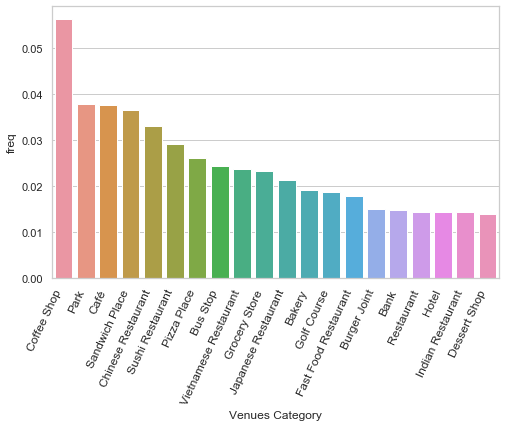

In [124]:
# viualize it in a simple bar chart
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")
ax = sns.barplot(x="Venues Category", y="freq", data=cluster1_sorted)
plt.xticks(
    rotation=65, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium')


-looks like the chinese restaurant comes in 5th place, Japanese sushi comes in 6th, park is the second place

#### let's find out how many asian resturants are in each neighborhood candidate.

In [81]:
metrovan_venues['Venue Category'].unique()

array(['Golf Course', 'Golf Driving Range', 'Burger Joint', 'Café',
       'Pie Shop', 'Asian Restaurant', 'Gourmet Shop',
       'Seafood Restaurant', 'Deli / Bodega', 'Pizza Place', 'Restaurant',
       'Gastropub', 'Japanese Restaurant', 'Food Truck', 'Bar',
       'Chinese Restaurant', 'Sandwich Place', 'Cocktail Bar', 'Tea Room',
       'Dessert Shop', 'Coffee Shop', 'German Restaurant',
       'Italian Restaurant', 'Boxing Gym', 'Poke Place',
       'American Restaurant', 'Nightclub', 'Bakery', 'Park', 'Diner',
       'Brewery', 'French Restaurant', 'Music Store',
       'Latin American Restaurant', 'Beer Bar', 'Tapas Restaurant',
       'Breakfast Spot', 'Mexican Restaurant', 'Tech Startup',
       'Science Museum', 'Auto Dealership', 'Fried Chicken Joint',
       'Cheese Shop', 'Caribbean Restaurant', 'Ice Cream Shop', 'Circus',
       'Taco Place', 'Dive Bar', 'BBQ Joint', 'Movie Theater', 'Boutique',
       'Lounge', 'Plaza', 'Garden', 'Noodle House', 'Art Gallery',
       'F

-browse through the unique categories provided by foursquare, we can easily filter out all the **east asian cuisine** related keywords:
**Asian,Chinese,Japanese,Noodle,Ramen,Sushi,Shanghai,Cantonese,Vietnamese,Taiwanese**

In [83]:
#find out how many asian restaurants are in these venues we are exploring.
asianfood = metrovan_venues[metrovan_venues['Venue Category'].str.contains('Asian|Chinese|Japanese|Noodle|Ramen|Sushi|Shanghai|Cantonese|Vietnamese|Taiwanese')].reset_index(drop=True)
asianfood.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Id
0,Vancouver,"Vancouver - Strathcona,Chinatown,Downtown East...",49.278421,-123.092971,Phnom Penh,49.278517,-123.098214,Asian Restaurant,4aa7fa85f964a520704e20e3
1,Vancouver,"Vancouver - Strathcona,Chinatown,Downtown East...",49.278421,-123.092971,Kissa Tanto,49.280412,-123.098133,Japanese Restaurant,57242c7ecd1040df61be5d0b
2,Vancouver,"Vancouver - Strathcona,Chinatown,Downtown East...",49.278421,-123.092971,Bao Bei,49.279491,-123.100595,Chinese Restaurant,4b513a38f964a5200b4827e3
3,Vancouver,"Vancouver - Strathcona,Chinatown,Downtown East...",49.278421,-123.092971,Pidgin,49.281888,-123.104311,Asian Restaurant,4fae01d3e4b0861eac7a985a
4,Vancouver,"Vancouver - Strathcona,Chinatown,Downtown East...",49.278421,-123.092971,Torafuku,49.275951,-123.099814,Asian Restaurant,55af01e7498ef6fadceecda9


In [84]:
asianfood.shape[0]

343

-there are total of 343 asian restaurants near the neighborhood candiates. Let's add the rating of these restaurants from foursquare API.

In [99]:
foodrating=[]
for i in (range(len(asianfood))):
    venue_id = asianfood['Venue Id'][i]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        R=result['response']['venue']['rating']
        foodrating.append(R)
    except:
        foodrating.append('NaN')
ratings=pd.DataFrame(foodrating,columns=['Rating'])
asianfood=pd.merge(asianfood,ratings,left_index=True,right_index=True)

In [100]:
asianfood.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Id,Rating
0,Vancouver,"Vancouver - Strathcona,Chinatown,Downtown East...",49.278421,-123.092971,Phnom Penh,49.278517,-123.098214,Asian Restaurant,4aa7fa85f964a520704e20e3,8.4
1,Vancouver,"Vancouver - Strathcona,Chinatown,Downtown East...",49.278421,-123.092971,Kissa Tanto,49.280412,-123.098133,Japanese Restaurant,57242c7ecd1040df61be5d0b,8.2
2,Vancouver,"Vancouver - Strathcona,Chinatown,Downtown East...",49.278421,-123.092971,Bao Bei,49.279491,-123.100595,Chinese Restaurant,4b513a38f964a5200b4827e3,8.7
3,Vancouver,"Vancouver - Strathcona,Chinatown,Downtown East...",49.278421,-123.092971,Pidgin,49.281888,-123.104311,Asian Restaurant,4fae01d3e4b0861eac7a985a,8.6
4,Vancouver,"Vancouver - Strathcona,Chinatown,Downtown East...",49.278421,-123.092971,Torafuku,49.275951,-123.099814,Asian Restaurant,55af01e7498ef6fadceecda9,7.6


In [101]:
#there are resturants without ratings on four square, let's find out how many they are
len(asianfood[asianfood['Rating']=='NaN'])

35

In [102]:
#calculating median rating for all the asian resturuant in the list.
median_rating=asianfood[asianfood['Rating']!='NaN']['Rating'].median()
median_rating

7.0

-30 of these restaurants have no ratings, we can use the median rating (7.0) of all these Asian restauruant to replace the missing rating.

In [103]:
# use the median rating to replace NaN.
asianfood['Rating'].replace('NaN',median_rating,inplace=True)

In [125]:
#now let's find out which municiple has the most asian resturants in the area we are exploring.
asianfood[['Borough','Venue']].groupby('Borough').count().sort_values(['Venue'],ascending=False)

,Venue
Borough,
Vancouver,251
Burnaby,42
Richmond,28
Surrey,13
New Westminster,6
Coquitlam,3


##### Most Asian food resturants nearby

-looks like Vancouver has the most, 251 out of the 343 venues we are currently exploring. Burnaby and Richmond come in second and third place.

In [164]:
#Now let's find out which neigborhood has the most density in asian food. showing the top 10 neighborhood.
Mostvenues=asianfood[['Neighborhood','Venue']].groupby(['Neighborhood']).count().sort_values(['Venue'],ascending=False).head(10)
Mostvenues

,Venue
Neighborhood,
Richmond - North,23
"Vancouver - NW West End,Stanley Park",20
Vancouver - South Renfrew-Collingwood,19
"Burnaby - Maywood,Marlborough,Oakalla,Windsor",19
"Vancouver - West Kensington-Cedar Cottage,NE Riley Park-Little Mountain",18
Vancouver - North Grandview-Woodland,17
"Burnaby - Burnaby Heights,Willingdon Heights,West Central Valley",15
"Vancouver - West Mount Pleasant,West Riley Park-Little Mountain",15
"Vancouver - SE Riley Park-Little Mountain,SW Kensington-Cedar Cottage,NE Oakridge,North Sunset",13


##### Quality of food

-looks like although Richmond comes in third in the total restuarant number, Richmond North has the most asian food within the radius. 

In [129]:
#Let's calculate the average ratings of these resturaunts in each neighborhood and showing the top 10.
bestquality=asianfood[['Neighborhood','Rating']].groupby('Neighborhood').mean().sort_values(['Rating'],ascending=False)
bestquality.head(10)

,Rating
Neighborhood,
Vancouver - Bentall Centre,8.616667
"Vancouver - NE Downtown,Gastown,Harbour Centre,International Village,Victory Square,Yaletown",8.560000
"Vancouver - Waterfront,Coal Harbour,Canada Place",8.500000
Vancouver - Pacific Centre,8.500000
Vancouver - SW Downtown,8.433333
"Vancouver - SE West End,Davie Village",8.357143
"Vancouver - NW Shaughnessy,East Kitsilano,Quilchena",7.712500
"Vancouver - West Kerrisdale,South Dunbar-Southlands,Musqueam",7.700000
"Vancouver - West Fairview,Granville Island,NE Shaughnessy",7.560000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 <a list of 46 Text xticklabel objects>)

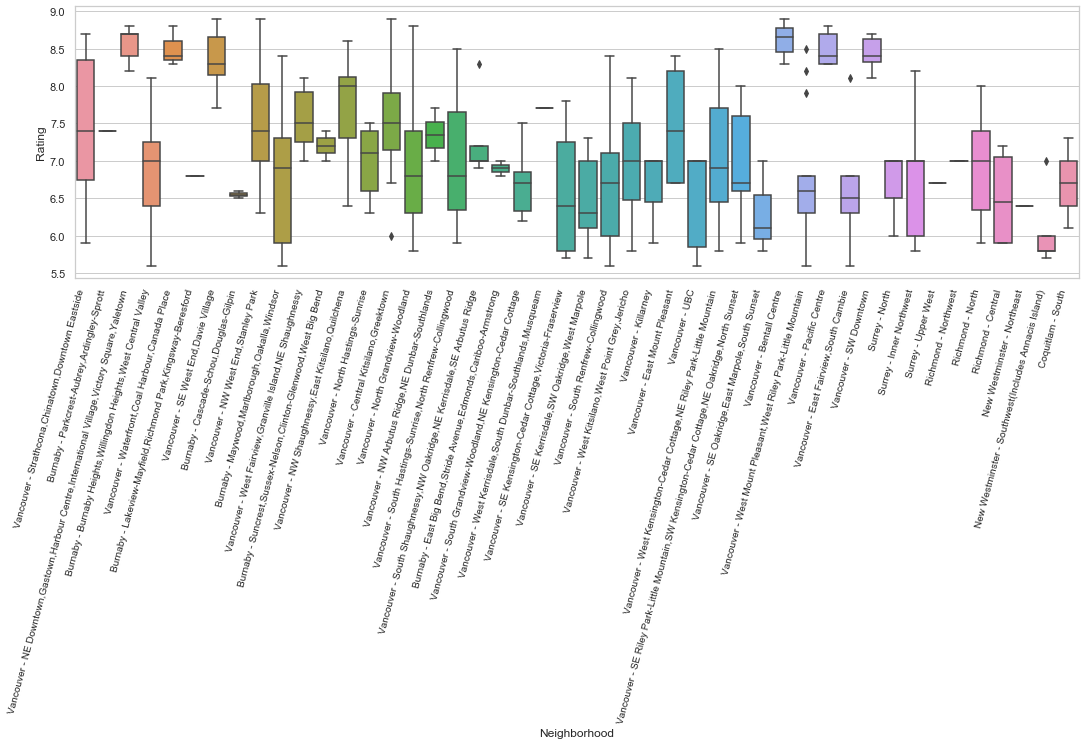

In [173]:
# visualize the the ratings with the boxplot
plt.figure(figsize=(18, 5))
sns.set(style="whitegrid")
ax = sns.boxplot(x=asianfood['Neighborhood'],y=asianfood['Rating'],data=asianfood)
plt.xticks(
    rotation=75, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')

-Asian restaurants with the best quality are in the Vancouver downtown area, however the sample size are small for some of these Neighborhood, we will focus on the neighborhoods with the most Asian restaurant first then use the average rating as a reference.

In [140]:
#lets add the ratings to top 10 neighborhoods has the best rating for asian food.
df_top10=pd.merge(Mostvenues,bestquality,on='Neighborhood')
df_top10

,Venue,Rating
Neighborhood,,
Richmond - North,23,6.917391
"Vancouver - NW West End,Stanley Park",20,7.510000
Vancouver - South Renfrew-Collingwood,19,6.763158
"Burnaby - Maywood,Marlborough,Oakalla,Windsor",19,6.715789
"Vancouver - West Kensington-Cedar Cottage,NE Riley Park-Little Mountain",18,7.066667
Vancouver - North Grandview-Woodland,17,6.935294
"Burnaby - Burnaby Heights,Willingdon Heights,West Central Valley",15,6.853333
"Vancouver - West Mount Pleasant,West Riley Park-Little Mountain",15,6.800000
"Vancouver - SE Riley Park-Little Mountain,SW Kensington-Cedar Cottage,NE Oakridge,North Sunset",13,6.892308


-looks like although theses neighborhoods are having most Asian food nearby, the ratings are just average. This may not be a big problem as these authentic Asian cuisines usually don't have a fancy set up and luxury environment which also contribute to the overall rating of the restaurants.

##### Most parks nearby

In [135]:
parks = metrovan_venues[metrovan_venues['Venue Category'].str.contains('Park')].reset_index(drop=True)
parks.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Id
0,Vancouver,"Vancouver - Strathcona,Chinatown,Downtown East...",49.278421,-123.092971,Creekside Park,49.274641,-123.102701,Park,4b7c2ccaf964a5201a822fe3
1,Vancouver,"Vancouver - Strathcona,Chinatown,Downtown East...",49.278421,-123.092971,Strathcona Park,49.275183,-123.084919,Park,4abe4197f964a520428c20e3
2,Vancouver,"Vancouver - Strathcona,Chinatown,Downtown East...",49.278421,-123.092971,MacLean Park,49.278809,-123.088546,Park,4bbebef598f4952118c2d163
3,Vancouver,"Vancouver - Strathcona,Chinatown,Downtown East...",49.278421,-123.092971,Crab Park,49.284990,-123.101327,Park,4aaaf0f4f964a5202a5820e3
4,Vancouver,"Vancouver - Strathcona,Chinatown,Downtown East...",49.278421,-123.092971,Trillium Park,49.274308,-123.093691,Park,4d9fad3083f0b1f7b0ae9fc7


In [138]:
parks_nearby=parks[['Neighborhood','Venue']].groupby('Neighborhood').count().sort_values(['Venue'],ascending=False)
parks_nearby.head()

,Venue
Neighborhood,
Vancouver - North Hastings-Sunrise,8
"Vancouver - Strathcona,Chinatown,Downtown Eastside",5
Vancouver - South Renfrew-Collingwood,5
"Vancouver - NW West End,Stanley Park",5
"Vancouver - South Hastings-Sunrise,North Renfrew-Collingwood",4


In [141]:
df_top10=pd.merge(df_top10,parks_nearby,on='Neighborhood')

In [144]:
df_top10.rename(columns={'Venue_x':'Asian Resturant','Venue_y':'Parks'},inplace=True)
df_top10

,Asian Resturant,Rating,Parks
Neighborhood,,,
Richmond - North,23,6.917391,1
"Vancouver - NW West End,Stanley Park",20,7.510000,5
Vancouver - South Renfrew-Collingwood,19,6.763158,5
"Vancouver - West Kensington-Cedar Cottage,NE Riley Park-Little Mountain",18,7.066667,1
Vancouver - North Grandview-Woodland,17,6.935294,1
"Burnaby - Burnaby Heights,Willingdon Heights,West Central Valley",15,6.853333,3
"Vancouver - West Mount Pleasant,West Riley Park-Little Mountain",15,6.800000,2
"Vancouver - SE Riley Park-Little Mountain,SW Kensington-Cedar Cottage,NE Oakridge,North Sunset",13,6.892308,2
"Vancouver - SE Kerrisdale,SW Oakridge,West Marpole",12,6.458333,3


#### Skytrain stations nearby

first, let's find the nearby venues of each station using foursquare API, radius set at 1km.

In [153]:
def getNearbyVenues2(stations, latitudes, longitudes):
    radius=1000
    LIMIT=200
    venues_list=[]
    for station, lat, lng in zip(stations, latitudes, longitudes):   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            station, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results]) # we need venue id for further exploring the venues

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 'Station_Latitude', 'Station_Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude']
    
    return(nearby_venues)

In [154]:
stationnearby = getNearbyVenues2(stations=df_station['Station'],latitudes=df_station['Lat'],longitudes=df_station['Lng'])

In [155]:
stationnearby.head()

,Station,Station_Latitude,Station_Longitude,Venue,Venue Latitude,Venue Longitude
0,22nd Street Station,49.200065,-122.949015,Grimston Park,49.202087,-122.942628
1,22nd Street Station,49.200065,-122.949015,Pho Maxima Restaurant,49.203505,-122.949788
2,22nd Street Station,49.200065,-122.949015,Lindt Outlet Boutique,49.191788,-122.948675
3,22nd Street Station,49.200065,-122.949015,Banana Republic,49.192818,-122.950226
4,22nd Street Station,49.200065,-122.949015,Tommy Hilfiger,49.193634,-122.948272


In [157]:
df_stationnearby=pd.merge(stationnearby,metrovan_venues,on=['Venue Latitude','Venue Longitude'])
df_stationnearby.head()
df_stationnearby[['Station','Neighborhood','Neighborhood Latitude','Neighborhood Longitude']].head()

,Station,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,22nd Street Station,New Westminster - Southwest(Includes Annacis I...,49.18822,-122.943376
1,22nd Street Station,New Westminster - Southwest(Includes Annacis I...,49.18822,-122.943376
2,22nd Street Station,New Westminster - Southwest(Includes Annacis I...,49.18822,-122.943376
3,22nd Street Station,New Westminster - Southwest(Includes Annacis I...,49.18822,-122.943376
4,22nd Street Station,New Westminster - Southwest(Includes Annacis I...,49.18822,-122.943376


In [161]:
#find out how many venues we got before for each neighborhood is also in the close radius of the skytrain station.
station_nearby_list=df_stationnearby[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Station']].groupby(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']).size().reset_index(name='venue_count')

In [160]:
station_nearby_list.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,venue_count
0,"Burnaby - Burnaby Heights,Willingdon Heights,W...",49.275565,-123.002918,23
1,"Burnaby - Government Road,Lake City,SFU,Burnab...",49.266244,-122.931096,2
2,"Burnaby - Lakeview-Mayfield,Richmond Park,King...",49.226349,-122.945568,1
3,"Burnaby - Maywood,Marlborough,Oakalla,Windsor",49.230275,-122.997770,148
4,"Burnaby - Parkcrest-Aubrey,Ardingley-Sprott",49.266060,-122.959220,12


-the number of venues can be a good indication of how close-by the station is, for example the Burnaby- Maywood has 148 venues in the close radius of skytrain stations, we can consider it is closer to a station than Burnaby -lakeview Mayfield, which only has 1 venus nearby in the radius of a skytrain station.

In [168]:
#now let's plot these neighborhood on the map.
map_vancouver_stationnearby= folium.Map(location=Metro_Vancouver, zoom_start=11.5)

# Add the skytrain stations, green train icon with popup.  
for lat, lng, station in zip(df_station['Lat'], df_station['Lng'], df_station['Station']):
    label = station
    label = folium.Popup(label, parse_html=False)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='green',icon="train", prefix='fa')
        ).add_to(map_vancouver_stationnearby)
# Add the neighborhoods, red circle with pop up.
for lat, lng, neighborhood in zip(station_nearby_list['Neighborhood Latitude'],station_nearby_list['Neighborhood Longitude'],station_nearby_list['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='#498ee3',
        fill=True,
        fill_color='#e6aab6',
        fill_opacity=0.5,
        parse_html=False).add_to(map_vancouver_stationnearby)
map_vancouver_stationnearby

Finally, let's add the venue count column to the top 10 neighborhoods with Asian restaurants and parks we generated before.

In [162]:
df_candidates=pd.merge(df_top10,station_nearby_list,on='Neighborhood')
df_candidates

,Neighborhood,Asian Resturant,Rating,Parks,Neighborhood Latitude,Neighborhood Longitude,venue_count
0,Richmond - North,23,6.917391,1,49.186035,-123.118680,54
1,Vancouver - South Renfrew-Collingwood,19,6.763158,5,49.239638,-123.039467,62
2,Vancouver - North Grandview-Woodland,17,6.935294,1,49.280700,-123.067240,4
3,"Burnaby - Burnaby Heights,Willingdon Heights,W...",15,6.853333,3,49.275565,-123.002918,23
4,"Vancouver - West Mount Pleasant,West Riley Par...",15,6.800000,2,49.247900,-123.111442,55
5,"Vancouver - SE Kerrisdale,SW Oakridge,West Mar...",12,6.458333,3,49.213221,-123.141921,4


-After doing a visual check of all these 6 neighborhoods on the map, we don't think Vancouver-North Grandview-woodland is in very close proximity to the stations compared to other neighborhoods on the list.

In [171]:
df_candidates['Neighborhood'].values

array(['Richmond - North', 'Vancouver - South Renfrew-Collingwood',
       'Vancouver - North Grandview-Woodland',
       'Burnaby - Burnaby Heights,Willingdon Heights,West Central Valley',
       'Vancouver - West Mount Pleasant,West Riley Park-Little Mountain',
       'Vancouver - SE Kerrisdale,SW Oakridge,West Marpole'], dtype=object)

### Results and Discussion <a name='results'></a>

We have analysed total of 62 neighborhoods in Metro Vanoucover and we have focus on the 48 neighborhoods in the largest cluster that share the similar urbanized characteristics.
These 48 neighborhoods has parks and Asian restaurant in the top 10 venues categories, which is what our clients are looking for.

Our analysis shows there are 343 east asian resturants outside the 2720 venues we analysed in Metro Vancouver Area, 251 of them are in Vancouver; however Richmond North as a neighborhood has the most Asian food (23).

The median rating of all 343 asian resturant being analysed is 7.0, the highest ratings are found in Downtown Vanoucer area, however the sample size is relatively small, so there might be sampling bias.
Most neighborhoods on the top 10 most asian food list has the average rating closer to the median. Most authentic asian resturaunts do not have fancy set-up and good dining environment that could contribute to a higher rating.

All the neighborhoods from the 10 asian food list has at least 1 park nearby. 
6 of them have skytrain stations nearby.
After re-evaluate the distance on the map, and taking everything into consideration, we are recommending 4 neighborhoods below based on the criterias
(2 of them in Vancouver, 1 in Richomond and 1 in Burnaby:

**1. Richmond - North, most asian food near by and close to Aberdeen and Bridgeport station, average rating of the food around 6.9, 1 park nearby.**

**2. Vancouver - South Renfrew-Collingwood, average rating of the fodd is around 6.8 and 5 parks nearby, close to Joyce-collingwood and 29 ave station.**

**3. Burnaby - Burnaby Heights,Willingdon Heights,West Central Valley, averge rating around 6.85 and 3 parks nearby, close to brentwood town center station.**

**4. Vancouver - West Mount Pleasant,West Riley Park-Little Mountain, averge rating around 6.8 and 2 parks nearby, close to King Edward station.**

There are some exceptions could be taken into consideration, for example, with larger asian population density, Chinatown area has lots of asian food with higher rating which could be taken into consideration; however above 4 recommendations are what the data told us so far. A future analysis can be down on the smaller divisions of the neighborhoods.

### Conclusion <a name='conclusion'></a>

Purpose of this analysis is to compare neighborhoods based on very special criterias set by the clients. Clients have been recommended a rough idea of the neighborhood selections based on the data available to us. Further desicion on the rental will be made by the clients with the consideration of additional factors for example the actual rental costs, school nearby or crime rate, etc. These additional factors can be included in the future analysis if the additional data is available.

A different criteria set by clients coming from different culture background can be analysed with similar methodology.
We hope the analysis can be used to provide more insights before people moving to an unfamiliar city.

April 2020